<h1><center>Predicting YouTube Rewind Moments</center></h1>
<h2><center>IST 736 Final Project</center></h2>  

### Team  
- Ian Aliman  
- LaRue Brown  
- Hannah Jordan  
- Gayathri Sanjeev  

## Setup  

Import print function from *future*

In [1]:
from __future__ import print_function  

Import libraries and functions 

In [2]:
from sklearn.feature_extraction.text import CountVectorizer  
from sklearn.model_selection import train_test_split  
from sklearn.model_selection import cross_val_score  
from sklearn.metrics import classification_report  
from sklearn.model_selection import GridSearchCV  
from nltk.tokenize import word_tokenize  
from nltk.stem import WordNetLemmatizer  
from nltk.corpus import stopwords  
from sklearn.svm import SVC  
from nltk import FreqDist  
import pandas as pd  
import numpy as np  
import warnings  
import json  
import os  
import re  

## Data Acquisition  

In [3]:
files = [file for file in os.walk('.\\data')]  
analytics_files = files[1][2]  
caption_files = files[2][2]  

## Data Cleansing  

### Prepare Analytics Data  

In [4]:
analytics_data = []  

for file in analytics_files:  
    with open('.\\data\\Analytics\\{}'.format(file), 'r') as f:  
        
        # load json data from file, and select the 'rows' key  
        metrics = json.load(f)['rows']  
        
    # convert to dataframe  
    metrics = pd.DataFrame(metrics, columns = ['elapsedVideoTimeRatio',  
                                                'audienceWatchRatio',  
                                                'relativeRetentionPerformance'])  
        
    # remove '.txt' from file name  
    file = file.replace('.txt', '')  
        
    # add filename to metrics dataframe  
    metrics['videoID'] = file  
        
    # append metrics dataframe to analytics_data  
    analytics_data.append(metrics)  
    
# convert to dataframe      
analytics_data = pd.concat(analytics_data)  

### Prepare Caption Data  

In [5]:
caption_data = []  

for file in caption_files:  
    with open('.\\data\\Captions\\{}'.format(file), 'r') as f: 
        
        # read caption files, remove blank rows 
        caption_list = [line.strip() for line in f.readlines() if line.strip()]  
        
    index = 0  
    time = []  
    caption = []  
    
    # separate time and caption data  
    for line in caption_list:  
        time.append(line) if index % 2 == 0 else caption.append(line)  
        index += 1  
    
    # save time and caption as dataframe  
    captions = pd.DataFrame({'Time': time, 'Caption': caption})  
    
    # remove '.sbv' and 'captions ' from filename  
    file = file.replace('.sbv', '')  
    file = file.replace('captions ', '')  
    
    # add filename to captions dataframe  
    captions['videoID'] = file  
    
    # create start and end columns  
    captions[['Start', 'End']] = captions.Time.str.split(',', expand = True)  
    
    # convert start and end to times  
    captions['Start'] = pd.to_timedelta(captions['Start'])  
    captions['End'] = pd.to_timedelta(captions['End'])  

    # append captions dataframe to caption_data  
    caption_data.append(captions)  
    
# convert to dataframe  
caption_data = pd.concat(caption_data)  

# add max time per video  
caption_data['videoEnd'] = caption_data.groupby('videoID')['End'].transform('max')  

# create elapsed video time ratio & round to 2 decimal places  
caption_data['elapsedVideoTimeRatio'] = caption_data['End'] / caption_data['videoEnd']  
caption_data['elapsedVideoTimeRatio'] = caption_data['elapsedVideoTimeRatio'].round(2)  

### Combine Caption and Analytics Data  

In [6]:
combined_data = pd.merge(caption_data, analytics_data, how = 'inner', on = ['videoID', 'elapsedVideoTimeRatio'])  

### Label Data  

In [7]:
combined_data['relativeRetention'] = np.where(combined_data['relativeRetentionPerformance'] < \
                                   combined_data['audienceWatchRatio'], 1, 0)  

### Select Data Columns  

In [8]:
clean_data = combined_data[['videoID', 'Caption', 'relativeRetention']]  
clean_data.head(25)  

,videoID,Caption,relativeRetention
0,gGe6cs-CdQA,[Music],1
1,gGe6cs-CdQA,welcome only eight of you remain and,1
2,gGe6cs-CdQA,once again the teams are even foreign,1
3,gGe6cs-CdQA,team Peck and foreign team Nunez this,1
4,gGe6cs-CdQA,week we are testing technical,1
5,gGe6cs-CdQA,application technical application is,1
6,gGe6cs-CdQA,what's happening when you put the needle,1
7,gGe6cs-CdQA,to the skin is your line work clean is,1
8,gGe6cs-CdQA,your shading smooth with this flash,1
9,gGe6cs-CdQA,challenge you must tattoo one of the,1


### Multinomial Naive Bayes    

In [23]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [24]:
#separate the rewind label from the captions
text = np.array(clean_data['Caption'])
label = np.array(clean_data['relativeRetention'])

In [25]:
captionVect = CountVectorizer(analyzer = 'word', stop_words='english', lowercase = True)
XCaption=captionVect.fit_transform(text)
ColumnNames=captionVect.get_feature_names()
print("Column names: ", ColumnNames)
CaptionDF=pd.DataFrame(XCaption.toarray(),columns=ColumnNames)
print(CaptionDF)

Column names:  ['000', '100', '11', '12', '13', '14', '15', '16', '17', '20', '200', '21', '24', '25', '30', '39', '3d', '400', '50', '666', 'aaron', 'ability', 'able', 'absolutely', 'abstract', 'accomplished', 'action', 'active', 'actual', 'actually', 'adapt', 'added', 'advantage', 'afraid', 'aggressive', 'ahead', 'ain', 'air', 'airs', 'alien', 'alliance', 'allows', 'alright', 'amazing', 'american', 'americans', 'anatomy', 'anchor', 'angel', 'angeles', 'angelic', 'angry', 'anna', 'anthony', 'anybody', 'anymore', 'apocalypse', 'apocalyptic', 'apparently', 'appearance', 'applause', 'apples', 'application', 'appreciate', 'apprentice', 'approach', 'approximately', 'aquas', 'area', 'areas', 'aren', 'armed', 'art', 'artist', 'artistic', 'artistry', 'artists', 'artwork', 'ash', 'ashes', 'ashlee', 'ask', 'asked', 'asking', 'ass', 'assign', 'assigned', 'attention', 'attitude', 'away', 'awesome', 'awful', 'baby', 'babysitting', 'background', 'bad', 'badass', 'baddest', 'baddie', 'balance', 'bal

In [26]:
## Now update the row names
MyDict={}
for i in range(0, len(label)):
    MyDict[i] = label[i]

print("MY DICT:", MyDict)
        
CaptionDF=CaptionDF.rename(MyDict, axis="index")
print(CaptionDF)

MY DICT: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 1, 53: 1, 54: 1, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1, 100: 1, 101: 1, 102: 1, 103: 1, 104: 1, 105: 1, 106: 1, 107: 1, 108: 1, 109: 1, 110: 1, 111: 0, 112: 0, 113: 0, 114: 0, 115: 1, 116: 1, 117: 1, 118: 1, 119: 1, 120: 1, 121: 1, 122: 1, 123: 1, 124: 1, 125: 1, 126: 1, 127: 1, 128: 1, 129: 1, 130: 1, 131: 1, 132: 1, 133: 1, 134: 1, 135: 1, 136: 1, 137:

In [27]:
#replace any null values
CaptionDF=CaptionDF.fillna(0)

# Build data frames to store words and TF-IDF results
words, values = pd.DataFrame(np.array(captionVect.get_feature_names())), pd.DataFrame(np.array(XCaption.mean(axis=0))).transpose()

# Build a dataframe with the words and tf-idf results to view words with both the highest and lowest scores. 
final_results = pd.concat([words, values], axis=1)
final_results.columns = ['words', 'CountVect']
final_results = final_results.sort_values(by=['CountVect'], ascending=False)
print(final_results)

            words  CountVect
875          like   0.081441
1534       tattoo   0.050346
807          just   0.048371
632         gonna   0.043929
1228       really   0.037512
442           don   0.035538
1687         want   0.031589
1269        right   0.029121
827          know   0.028134
1574        think   0.021718
1753         yeah   0.021718
896          look   0.020237
210      canvases   0.019743
281         color   0.019250
633          good   0.018756
1597        today   0.018263
1590         time   0.017769
867           let   0.017275
1738         work   0.016782
888        little   0.016782
636           got   0.016782
1671           ve   0.015795
924          make   0.015301
531          feel   0.014808
907           lot   0.014314
1052         okay   0.014314
232     challenge   0.014314
1542         team   0.014314
1698          way   0.014314
657          guys   0.013820
...           ...        ...
880       limited   0.000494
879         limbs   0.000494
878       lili

In [28]:
print('Top 10 highest frequency: ') 
print(final_results.iloc[:10, :], '\n')

Top 10 highest frequency: 
       words  CountVect
875     like   0.081441
1534  tattoo   0.050346
807     just   0.048371
632    gonna   0.043929
1228  really   0.037512
442      don   0.035538
1687    want   0.031589
1269   right   0.029121
827     know   0.028134
1574   think   0.021718 



In [29]:
print('Bottom 10 lowest frequency: ')
print(final_results.iloc[1754:, :])

Bottom 10 lowest frequency: 
            words  CountVect
196           bye   0.000494
902           los   0.000494
200   calligraphy   0.000494
899         loony   0.000494
198          calf   0.000494
199        called   0.000494
895        longer   0.000494
893      location   0.000494
892          load   0.000494
1763         zone   0.000494


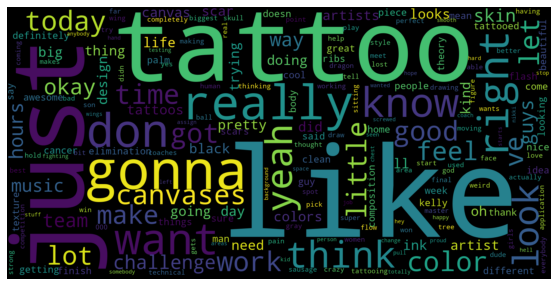

In [30]:
from wordcloud import WordCloud, ImageColorGenerator
# Create a dictionary with the words and TF-IDF values that will be passed into WordCloud()
d = {}
for a, x in final_results.values:
    d[a] = x

# Adjust image parameters to increase height and width of figure, create word cloud, and show image
plt.rcParams['figure.figsize'] = [10, 5]
wordcloud = WordCloud(scale=5)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [31]:
from sklearn.model_selection import train_test_split
#split the data using train test split function
caption_train, caption_test, label_train, label_test = train_test_split(CaptionDF,label, test_size=0.3)

## Now we have a training set and a testing set. 
print("The training set is:")
print(caption_train)
print("The testing set is:")
print(caption_test)

#write the data into files
caption_train_file = caption_train.to_csv (r'caption_train.csv', index = None, header=True)
caption_test_file = caption_test.to_csv (r'caption_test.csv', index = None, header=True)

The training set is:
    000  100  11  12  13  14  15  16  17  20  ...  year  years  yellow  yep  \
0     0    0   0   0   0   0   0   0   0   0  ...     0      0       0    0   
1     0    0   0   0   0   0   0   0   0   0  ...     0      0       0    0   
0     0    0   0   0   0   0   0   0   0   0  ...     0      0       0    0   
0     0    0   0   0   0   0   0   0   0   0  ...     0      0       0    0   
1     0    0   0   0   0   0   0   0   0   0  ...     0      0       0    0   
0     0    0   0   0   0   0   0   0   0   0  ...     0      0       0    1   
1     0    0   0   0   0   0   0   0   0   0  ...     0      0       0    0   
0     0    0   0   0   0   0   0   0   0   0  ...     0      0       0    0   
1     0    0   0   0   0   0   0   0   0   0  ...     0      0       0    0   
1     0    0   0   0   0   0   0   0   0   0  ...     0      0       0    0   
0     0    0   0   0   0   0   0   0   0   0  ...     0      0       0    0   
1     0    0   0   0   0   0   

In [32]:
from sklearn.naive_bayes import MultinomialNB

#Create the modeler
MyModelNB= MultinomialNB()
NBModel = MyModelNB.fit(caption_train, label_train)
Prediction = NBModel.predict(caption_test)
print("The prediction from NB is:")
print(Prediction)
print("The actual labels are:")
print(label_test)

The prediction from NB is:
[1 0 0 1 0 1 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0
 1 1 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0 0 0 0 1 0 0
 1 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 0 0 1
 0 0 0 1 1 1 0 1 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 1 1
 0 0 0 0 1 1 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0
 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1
 1 0 0 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1
 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0
 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0 1 0 0 0 0 1 0
 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 0 0 1 1 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 0 0 1 1 1 0 

In [33]:
## confusion matrix - The confusion matrix is square and is labels X labels. We have two labels, so ours will be 2X2
#The matrix shows rows are the true labels and columns are predicted

from sklearn.metrics import confusion_matrix
labels = [0,1]
cnf_matrix = confusion_matrix(label_test, Prediction, labels)
print("The confusion matrix is:")
print(cnf_matrix)

The confusion matrix is:
[[265 103]
 [160  80]]


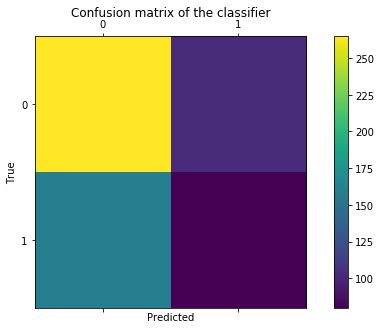

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cnf_matrix)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [35]:
### prediction probabilities
## columns are the labels in alphabetical order
## The decinal in the matrix are the prob of being that label
print(np.round(NBModel.predict_proba(caption_test),2))

#Accuracy score of the model
print ("Score:", NBModel.score(caption_test, label_test))

[[0.26 0.74]
 [0.98 0.02]
 [0.94 0.06]
 ...
 [0.59 0.41]
 [0.47 0.53]
 [0.5  0.5 ]]
Score: 0.5674342105263158


In [36]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
# Perform 10-fold cross validation
scores = cross_val_score(NBModel, CaptionDF, label, cv=6)
print ("Cross-validated scores:", scores)

#get the mean of each fold 
print("Accuracy of Model with Cross Validation is:",scores.mean() * 100)

Cross-validated scores: [0.53982301 0.5147929  0.56213018 0.58753709 0.59643917 0.57863501]
Accuracy of Model with Cross Validation is: 56.3226226956171


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import string

In [ ]:
#separate the rewind label from the captions
text = np.array(clean_data['Caption'])
label = np.array(clean_data['relativeRetention'])


In [ ]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles) if t not in stopwords.words('english') or string.punctuation]
    
##Build the vectorizer
#pattern='r/^[a-zA-Z]{4}$/'
#pattern="[^r\P{P}]+"
  
BVect2=CountVectorizer(analyzer = 'word',
                     stop_words='english',
                     #token_pattern='(?u)[a-zA-Z]+',
                     #token_pattern=pattern,
                     tokenizer=LemmaTokenizer(),
                     #strip_accents = 'unicode', 
                     lowercase = True,
                     binary = True
                     )

In [ ]:
X3=BVect2.fit_transform(text)
ColumnNames=BVect2.get_feature_names()
print("Column names: ", ColumnNames)
BVectbuilder2=pd.DataFrame(X3.toarray(),columns=ColumnNames)
print(BVectbuilder2)


In [ ]:

## Now update the row names
MyDict={}
for i in range(0, len(label)):
    MyDict[i] = label[i]

print("MY DICT:", MyDict)
        
BVectbuilder2=BVectbuilder2.rename(MyDict, axis="index")
print(BVectbuilder2)

## Replace the NaN with 0 because it actually 
## means none in this case
BVectbuilder2=BVectbuilder2.fillna(0)



In [ ]:

# Build data frames to store words and TF-IDF results
words, values = pd.DataFrame(np.array(BVect2.get_feature_names())), pd.DataFrame(np.array(X3.mean(axis=0))).transpose()

# Build a dataframe with the words and tf-idf results to view words with both the highest and lowest scores. 
final_results = pd.concat([words, values], axis=1)
final_results.columns = ['words', 'CountVect']
final_results = final_results.sort_values(by=['CountVect'], ascending=False)
print(final_results)
print('Top 10 highest frequency: ') 
print(final_results.iloc[:10, :], '\n')


In [ ]:

print('Bottom 10 lowest frequency: ')
print(final_results.iloc[1646:, :])

In [ ]:
from wordcloud import WordCloud, ImageColorGenerator
# Create a dictionary with the words and TF-IDF values that will be passed into WordCloud()
d = {}
for a, x in final_results.values:
    d[a] = x

# Adjust image parameters to increase height and width of figure, create word cloud, and show image
plt.rcParams['figure.figsize'] = [10, 5]
wordcloud = WordCloud(scale=5)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
#split the data using train test split function
caption_train, caption_test, label_train, label_test = train_test_split(BVectbuilder2,label, test_size=0.3)

In [ ]:
from sklearn.naive_bayes import BernoulliNB
BernModelL2 = BernoulliNB()
BernModelL2.fit(caption_train, label_train)
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
Prediction_BL2 = BernModelL2.predict(caption_test)
print("Bernoulli prediction:\n", Prediction_BL2)
print("Actual:")
print(label_test)


In [ ]:
from sklearn.metrics import confusion_matrix
labels = [0, 1]
cnf_matrix = confusion_matrix(label_test, Prediction_BL2, labels)
print("The confusion matrix is:")
print(cnf_matrix)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cnf_matrix)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
### prediction probabilities
## columns are the labels in alphabetical order
## The decinal in the matrix are the prob of being
## that label
from sklearn.model_selection import cross_val_score, cross_val_predict
print(np.round(BernModelL2.predict_proba(caption_test),2))

#Accuracy score of the model
print ("Score:", BernModelL2.score(caption_test, label_test))

#cross-validation method
scores_BL2 = cross_val_score(BernModelL2, BVectbuilder2, label, scoring='accuracy', cv=10)
print ("Cross-validated scores:", scores_BL2)

#get the mean of each fold 
print("Accuracy of Model with Cross Validation is:",scores_BL2.mean() * 100)


### Support Vector Machines  

#### Tokenize Words  

In [38]:
def create_tokens(captions):  
    # replace text in brackets with blanks  
    captions = [re.sub(r'\[.+?\]', '', caption) for caption in captions]   
    
    # remove blanks  
    captions = [caption for caption in captions if caption != '']  
    
    # convert to lowercase
    captions = [caption.lower() for caption in captions]  
    
    # tokenize 
    all_words = [word_tokenize(caption) for caption in captions]  
    
    # flaten tokens list
    tokens = []  
    
    for sublist in all_words:  
        for token in sublist:  
            tokens.append(token)  
            
    # remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]  
    
    # replace non-words with blanks
    tokens = [re.sub('^[^A-Za-z]*$', '', word) for word in tokens]  
    
    # replace words that begin with '  
    tokens = [re.sub('^\'.+?$', '', word) for word in tokens]  
    tokens = [word for word in tokens if word != '']  
    
    # lemmatize words
    tokens = [WordNetLemmatizer().lemmatize(word) for word in tokens]
    
    return tokens  

#### Finalize data

In [39]:
# Tokenize all comments  
tokens = create_tokens(clean_data['Caption'])  

In [40]:
# tokenize each comment individually
documents = [create_tokens(pd.Series(caption)) for caption in clean_data['Caption']]  

In [41]:
# create dataframe with captions and labels  
data = [' '.join(words) for words in documents]  
data = pd.DataFrame({'relativeRetention': clean_data['relativeRetention'],  
                    'Caption': data})  
data = data[data['Caption'] != '']  

#### Vectorizer function

In [42]:
def count_vectorizer(X, ngram = 1, bln = False): 
    
    # define count vectorizer
    vec = CountVectorizer(input = 'content',  
                         encoding = 'utf-8',  
                         decode_error = 'replace',  
                         strip_accents = 'unicode',  
                         ngram_range = (1, ngram), 
                         binary = bln)  
    
    # fit and transform data  
    X_vec = vec.fit_transform(X)  
    
    # define features  
    features = vec.get_feature_names()  
    
    # convert to dataframe
    X_df = pd.DataFrame(X_vec.toarray(), columns = features)  
    
    return(X_df)  

In [43]:
unigram_counts = count_vectorizer(data['Caption'])  
bigram_counts = count_vectorizer(data['Caption'], ngram = 2)  

#### SVM evaluation function 

In [44]:
def svm_eval(X, y): 
    
    # partition data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)  
    
    # set cross-validatin parameters for grid search  
    tuned_parameters = [{'kernel': ['linear', 'rbf', 'poly'], 
                         'C':  [1, 5, 10, 50], 
                        'gamma': ['auto']}]  
    
    scores = ['precision', 'recall']  
    
    for score in scores:  
        
        warnings.filterwarnings('ignore')
        
        print('Tuning hyper-parameters for {}\n'.format(score))  
        
        # grid search and fit model  
        clf = GridSearchCV(SVC(C=1), tuned_parameters, cv = 10, scoring = score, iid = True, return_train_score = True)  
        clf.fit(X_train, y_train)  
        
        # print results
        print('Best parameters set found on development set:')  
        print(clf.best_estimator_)  
        print()  
        
        print('Best score found')  
        print(clf.best_score_)  
        print()  
        
        print('Cross validation results:')  
        
        params = pd.DataFrame(clf.cv_results_['params'])  
        mean_test_score = pd.Series(clf.cv_results_['mean_test_score'], name = 'mean test score')  
        std_test_score = pd.Series(clf.cv_results_['std_test_score'], name = 'std test score')  
        rank_test_score = pd.Series(clf.cv_results_['rank_test_score'], name = 'rank test score')  
        print(pd.concat([params, mean_test_score, std_test_score, rank_test_score], axis = 1))  
        print()  
          
            
        print('Detailed classification report:')  
        print('This model is trained on the full deplomet set.')  
        print('The scores are computed on the full evaluation set')  
        
        y_true, y_pred = y_test, clf.predict(X_test)  
        print(classification_report(y_true, y_pred))  

#### Evaluate unigrams and bigrams 

In [45]:
svm_eval(unigram_counts, data['relativeRetention'])

Tuning hyper-parameters for precision

Best parameters set found on development set:
SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Best score found
0.5209374956398997

Cross validation results:
     C gamma  kernel  mean test score  std test score  rank test score
0    1  auto  linear         0.501560        0.057168                3
1    1  auto     rbf         0.000000        0.000000                6
2    1  auto    poly         0.000000        0.000000                6
3    5  auto  linear         0.520937        0.040244                1
4    5  auto     rbf         0.000000        0.000000                6
5    5  auto    poly         0.000000        0.000000                6
6   10  auto  linear         0.510957        0.040182                2
7   10  auto     rbf         0.000000        0.0000

In [46]:
svm_eval(bigram_counts, data['relativeRetention'])

Tuning hyper-parameters for precision

Best parameters set found on development set:
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Best score found
0.5004725774659344

Cross validation results:
     C gamma  kernel  mean test score  std test score  rank test score
0    1  auto  linear         0.498756        0.062688                2
1    1  auto     rbf         0.000000        0.000000                5
2    1  auto    poly         0.000000        0.000000                5
3    5  auto  linear         0.485765        0.058192                4
4    5  auto     rbf         0.000000        0.000000                5
5    5  auto    poly         0.000000        0.000000                5
6   10  auto  linear         0.500473        0.042200                1
7   10  auto     rbf         0.000000        0.000

### Clustering  

In [1]:
import nltk
import pandas as pd
import sklearn
import re
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import os
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import string
from sklearn.cluster import KMeans

In [2]:
# Read in the file
RawfileName="/Users/HannahHa/Desktop/OneDrive - Syracuse University/04_2019 SUMMER/IST 736/FINAL PROJECT/COMMENTS_LABELED.csv"
FILE=open(RawfileName,"r")
TextData=pd.read_csv(RawfileName)

In [3]:
# Create empty CSV file for clean data
filename="/Users/HannahHa/Desktop/OneDrive - Syracuse University/04_2019 SUMMER/IST 736/FINAL PROJECT/CleanText.csv"
NEWFILE=open(filename,"w")
ToWrite="Label,Text\n"
NEWFILE.write(ToWrite)
NEWFILE.close()

In [4]:
# Open CleanText.csv for appending
NEWFILE=open(filename, "a")

In [5]:
# Create clean dataframe
MyFinalDF=pd.DataFrame()

In [6]:
# Create output file to see what code is doing
OutputFile="/Users/HannahHa/Desktop/OneDrive - Syracuse University/04_2019 SUMMER/IST 736/FINAL PROJECT/MyOutputFile.txt"
OUTFILE=open(OutputFile,"w")
OUTFILE.close()
OUTFILE=open(OutputFile,"a")

In [7]:
## Import NLTK list of stopwords
nltkstopwords = nltk.corpus.stopwords.words("english")

In [8]:
for row in FILE:
    RawRow="\n\nThe row is: " + row +"\n"
    OUTFILE.write(RawRow)
    Mylist=row.split(" ")
    NewList=[]
    for word in Mylist:
        PlaceInOutputFile = "The next word BEFORE is: " +  word + "\n"
        OUTFILE.write(PlaceInOutputFile)
        word=word.lower()
        word=word.lstrip()
        #word=word.strip("\n")
        #word=word.strip("\\n")
        word=word.replace(",","")
        word=word.replace(" ","")
        word=word.replace("_","")
        word=re.sub('\+', ' ',word)
        word=re.sub('.*\+\n', '',word)
        word=re.sub('zz+', ' ',word)
        word=word.replace("\t","")
        word=word.replace(".","")
        word=word.replace("-","")
        word=word.strip()
        if word not in ["", "\\", '"', "'", "*", ":", ";"]:
            if word not in nltkstopwords:
                if len(word) >= 3:
                    if not re.search(r'^\d', word):
                        NewList.append(word)
                        PlaceInOutputFile = "The next word AFTER is: " + word + "\n"
                        OUTFILE.write(PlaceInOutputFile)
    label=NewList[-1]
    PlaceInOutputFile = "\nThe label is: " +  label + "\n"
    OUTFILE.write(PlaceInOutputFile)
    NewList.pop() ## removes last item
    Text=" ".join(NewList)    
    ### More cleaning....
    Text=Text.replace("\\n","")
    Text=Text.strip("\\n")
    Text=Text.replace("\\'","")
    Text=Text.replace("\\","")
    Text=Text.replace('"',"")
    Text=Text.replace("'","")
    Text=Text.replace("s'","")
    Text=Text.lstrip()    
    ## Create the string you want to write to the NEWFILE...
    OriginalRow="ORIGINAL" + RawRow
    OUTFILE.write(OriginalRow)
    ToWrite=label+","+Text+"\n"
    NEWFILE.write(ToWrite)
    OUTFILE.write(ToWrite)

In [9]:
## CLOSE files
FILE.close()  
NEWFILE.close()
OUTFILE.close()

In [10]:
## Read new csv file into DF or into CounterVectorizer

MyTextDF = pd.read_csv(filename)
MyTextDF = MyTextDF.dropna(how='any', axis=0)

In [11]:
## Keep the labels

MyLabel = MyTextDF["Label"]

In [12]:
## Remove the labels from the DF

DF_noLabel = MyTextDF.drop(["Label"], axis=1)

In [13]:
## Build the LIST for CountVectorizer

MyList = []
for i in range(0, len(DF_noLabel)):
    NextText = DF_noLabel.iloc[i,0]
    MyList.append(NextText)

In [14]:
## Vectorize

MycountVect = CountVectorizer(input="content")

CV = MycountVect.fit_transform(MyList)

MyColumnNames = MycountVect.get_feature_names()

VectorizedDF_Text = pd.DataFrame(CV.toarray(), columns=MyColumnNames)

In [15]:
# Clean up list of tokens/columns
ColumnNamesList = list(VectorizedDF_Text.columns)
print(ColumnNamesList)

['24', '44', '56', 'able', 'about', 'absolute', 'absolutely', 'accent', 'accept', 'acceptable', 'accessible', 'achieve', 'acknowledge', 'across', 'act', 'acting', 'action', 'activity', 'actual', 'actually', 'add', 'admittance', 'adorable', 'advice', 'advised', 'affect', 'afford', 'aged', 'ago', 'agree', 'ahhhhhhhhhhhhhhhh', 'ahole', 'aint', 'air', 'aka', 'alert', 'alexis', 'allow', 'almost', 'along', 'alright', 'also', 'always', 'am', 'amazing', 'amd', 'ame', 'american', 'amount', 'amputees', 'and', 'angels', 'angle', 'ankle', 'annoying', 'another', 'anthony', 'anxiety', 'anybody', 'anymore', 'anyone', 'anything', 'apart', 'appearance', 'applied', 'appreciate', 'arent', 'arist', 'arm', 'around', 'arsehole', 'art', 'artist', 'artists', 'asf', 'ash', 'ashes', 'ashley', 'ask', 'asleep', 'ass', 'assigned', 'attached', 'attended', 'attention', 'attitude', 'aunt', 'australia', 'autism', 'average', 'away', 'awe', 'aweful', 'awesome', 'awful', 'awws', 'awwww', 'baby', 'back', 'bad', 'badass', 

In [16]:
## Remove columns 3 characters or shorter
for Cname in ColumnNamesList:
    if(len(Cname)<=3):
        VectorizedDF_Text = VectorizedDF_Text.drop(Cname, axis=1)
ColumnNamesList2 = list(VectorizedDF_Text.columns)
print(ColumnNamesList2)

['able', 'about', 'absolute', 'absolutely', 'accent', 'accept', 'acceptable', 'accessible', 'achieve', 'acknowledge', 'across', 'acting', 'action', 'activity', 'actual', 'actually', 'admittance', 'adorable', 'advice', 'advised', 'affect', 'afford', 'aged', 'agree', 'ahhhhhhhhhhhhhhhh', 'ahole', 'aint', 'alert', 'alexis', 'allow', 'almost', 'along', 'alright', 'also', 'always', 'amazing', 'american', 'amount', 'amputees', 'angels', 'angle', 'ankle', 'annoying', 'another', 'anthony', 'anxiety', 'anybody', 'anymore', 'anyone', 'anything', 'apart', 'appearance', 'applied', 'appreciate', 'arent', 'arist', 'around', 'arsehole', 'artist', 'artists', 'ashes', 'ashley', 'asleep', 'assigned', 'attached', 'attended', 'attention', 'attitude', 'aunt', 'australia', 'autism', 'average', 'away', 'aweful', 'awesome', 'awful', 'awws', 'awwww', 'baby', 'back', 'badass', 'badi', 'badly', 'ball', 'ballon', 'balloo', 'balloon', 'balls', 'band', 'basic', 'basically', 'bastards', 'battle', 'bawling', 'beads',

In [17]:
# Remove stopwords
nltkstopwords = nltk.corpus.stopwords.words("english")
stopwords = nltkstopwords + ["also", "and", "are", "you", "of", "let", "not", "the", "for", "why", "there", "one", "which"]

for Cname in ColumnNamesList2:
    if(Cname in stopwords):
        VectorizedDF_Text = VectorizedDF_Text.drop(Cname, axis=1)
ColumnNamesList3 = list(VectorizedDF_Text.columns)

In [18]:
# Combine tenses
for name1 in ColumnNamesList3:  
    for name2 in ColumnNamesList3:
        if(name1 == name2):
            print("skip")
        elif(name1.rstrip("ing") == name2):
            print("combining: ", name1, name2)
            VectorizedDF_Text[name2] = VectorizedDF_Text[name1] + VectorizedDF_Text[name2]
            VectorizedDF_Text = VectorizedDF_Text.drop([name1], axis=1)
ColumnNamesList4 = list(VectorizedDF_Text.columns)

for name1 in ColumnNamesList4:  
    for name2 in ColumnNamesList4:
        if(name1 == name2):
            pass
        elif(name1.rstrip("s") == name2):
            print("combining: ", name1, name2)
            VectorizedDF_Text[name2] = VectorizedDF_Text[name1] + VectorizedDF_Text[name2]
            VectorizedDF_Text = VectorizedDF_Text.drop([name1], axis=1)
ColumnNamesList5 = list(VectorizedDF_Text.columns)

for name1 in ColumnNamesList5:  
    for name2 in ColumnNamesList5:
        if(name1 == name2):
            pass
        elif(name1.rstrip("d") == name2):
            print("combining: ", name1, name2)
            VectorizedDF_Text[name2] = VectorizedDF_Text[name1] + VectorizedDF_Text[name2]
            VectorizedDF_Text = VectorizedDF_Text.drop([name1], axis=1)
ColumnNamesList6 = list(VectorizedDF_Text.columns)

for name1 in ColumnNamesList6:  
    for name2 in ColumnNamesList6:
        if(name1 == name2):
            pass
        elif(name1.rstrip("ly") == name2):
            print("combining: ", name1, name2)
            VectorizedDF_Text[name2] = VectorizedDF_Text[name1] + VectorizedDF_Text[name2]
            VectorizedDF_Text = VectorizedDF_Text.drop([name1], axis=1)
ColumnNamesList7 = list(VectorizedDF_Text.columns)

skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
combining:  balloon balloo
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
combining:  blending blend
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
combining:  building build
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
combining:  censoring censor
skip
skip
skip


combining:  details detail
combining:  dicks dick
combining:  draws draw
combining:  dreams dream
combining:  dudes dude
combining:  episodes episode
combining:  everyones everyone
combining:  favorites favorite
combining:  finals final
combining:  girls girl
combining:  gives give
combining:  hands hand
combining:  hurts hurt
combining:  ideas idea
combining:  issues issue
combining:  jerks jerk
combining:  judges judge
combining:  julias julia
combining:  kellys kelly
combining:  knows know
combining:  lines line
combining:  lives live
combining:  looks look
combining:  makes make
combining:  masters master
combining:  means mean
combining:  mikes mike
combining:  moths moth
combining:  names name
combining:  needs need
combining:  nipples nipple
combining:  nipplesssssss nipple
combining:  olivers oliver
combining:  parts part
combining:  peoples people
combining:  persons person
combining:  picks pick
combining:  pictures picture
combining:  reasons reason
combining:  reminds remin

In [19]:
## Convert data frame to matrix

MyMatrix = VectorizedDF_Text.values
print(MyMatrix)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [20]:
# KMeans Clustering

kmeans_object = sklearn.cluster.KMeans(n_clusters = 10)
kmeans_object.fit(MyMatrix)
prediction = kmeans_object.labels_
MyResults = pd.DataFrame([TextData.text, TextData.label, prediction]).T

## References  

"Appending pandas dataframes generated in a for loop", **stackoverflow**, available from [https://stackoverflow.com/questions/28669482/appending-pandas-dataframes-generated-in-a-for-loop](https://stackoverflow.com/questions/28669482/appending-pandas-dataframes-generated-in-a-for-loop).  Date accessed 18 August, 2019  

"How to Split a Column into Two Columns in Pandas?", **cmdline**, available from [https://cmdlinetips.com/2018/11/how-to-split-a-text-column-in-pandas/](https://cmdlinetips.com/2018/11/how-to-split-a-text-column-in-pandas/).  Date accessed 18 August, 2019  

"Parameter estimation using grid search with cross-validation", **Scikit Learn**, available from [https://scikit-learn.org/0.15/auto_examples/grid_search_digits.html](https://scikit-learn.org/0.15/auto_examples/grid_search_digits.html).  Date accessed 24 August, 2019  

"Python Pandas max value in a group as a new column", **stackoverflow**, available from [https://stackoverflow.com/questions/35640364/python-pandas-max-value-in-a-group-as-a-new-column](https://stackoverflow.com/questions/35640364/python-pandas-max-value-in-a-group-as-a-new-column).  Date accessed 18 August, 2019  

"Python/Pandas convert string to time only", **stackoverflow**, available from [https://stackoverflow.com/questions/37801321/python-pandas-convert-string-to-time-only](https://stackoverflow.com/questions/37801321/python-pandas-convert-string-to-time-only).  Date accessed 18 August, 2019  

"Python | Lemmatization with NLTK", **Geeks for Geeks**, available from [https://www.geeksforgeeks.org/python-lemmatization-with-nltk/#targetText=Python%20%7C%20Lemmatization%20with%20NLTK,similar%20meaning%20to%20one%20word.](https://www.geeksforgeeks.org/python-lemmatization-with-nltk/#targetText=Python%20%7C%20Lemmatization%20with%20NLTK,similar%20meaning%20to%20one%20word.).  Date accessed 24 August, 2019  

"Skipping Blank lines in read file python", **stackoverflow**, available from [https://stackoverflow.com/questions/40647881/skipping-blank-lines-in-read-file-python/40647964](https://stackoverflow.com/questions/40647881/skipping-blank-lines-in-read-file-python/40647964).  Date accessed 18 August, 2019  

"Take multiple lists into dataframe", **stackoverflow**, available from [https://stackoverflow.com/questions/30522724/take-multiple-lists-into-dataframe](https://stackoverflow.com/questions/30522724/take-multiple-lists-into-dataframe).  Date accessed 18 August, 2019  